# SMC@FCC: Influence of Resampling

## Setup

In [1]:
import numpy as np
from numpy.random import randn, choice

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

## Background

The idea is to solve the state filtering problem in the (possibly non-linear) state space model
$$
\begin{align}
    X_t \,\big|\, \left(X_{t - 1} = x_{t - 1}\right) &\sim p\left(x_t \,\big|\, x_{t - 1}\right) \\
    Y_t \,\big|\, \left(X_t = x_t\right) &\sim p\left(y_t \,\big|\, x_t\right)
\end{align}
$$
This means to find $p\left(x_t \,\big|\, y_{1:t}\right)$. 

In the construction of e.g. the bootstrap particle filter, the role of resampling is emphasized. These notes are to investigate into the role of resampling in case of the very simple linear Gaussian state space model.

Assume here that
$$
\begin{align}
    X_{t + 1} &= 0.6 X_t + 0.5 E_t \\
    Y_t &= X_t + 0.8 V_t \\
    X_0 &\sim \mathcal{N}\left(0, 1\right)
\end{align}
$$
where $E_t, V_t \sim \mathcal{N}\left(0, 1\right)$. We then get
$$
\begin{align}
    p\left(x_t \,\big|\, x_{t - 1}\right) &= \mathcal{N}\left(0.6 x_{t - 1}, 0.5^2\right) \\
    p\left(y_t \,\big|\, x_t \right) &= \mathcal{N}\left(x_t, 0.8^2\right)
\end{align}
$$

## Simulate from the model

In [2]:
# total amount of time-steps
tmax = 500
xs = np.zeros((tmax + 1,))
ys = np.zeros((tmax,))

xs[0] = randn()
for t in range(tmax):
    xs[t + 1] = 0.6 * xs[t] + 0.5 * randn()
    ys[t] = xs[t + 1] + 0.8 * randn()

## Visualise simulated time-series

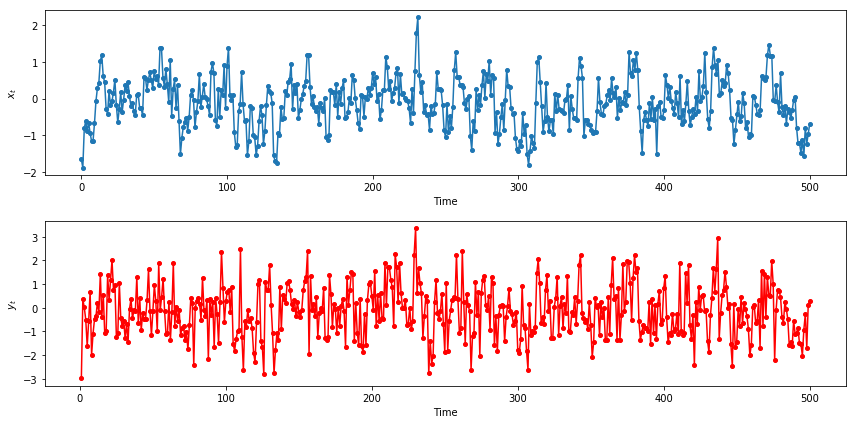

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].plot(range(tmax + 1), xs, 'o-', markersize=4)
axs[0].set_xlabel('Time');
axs[0].set_ylabel('$x_t$');

axs[1].plot(range(1, tmax + 1), ys, 'o-r', markersize=4)
axs[1].set_xlabel('Time');
axs[1].set_ylabel('$y_t$');

fig.tight_layout();

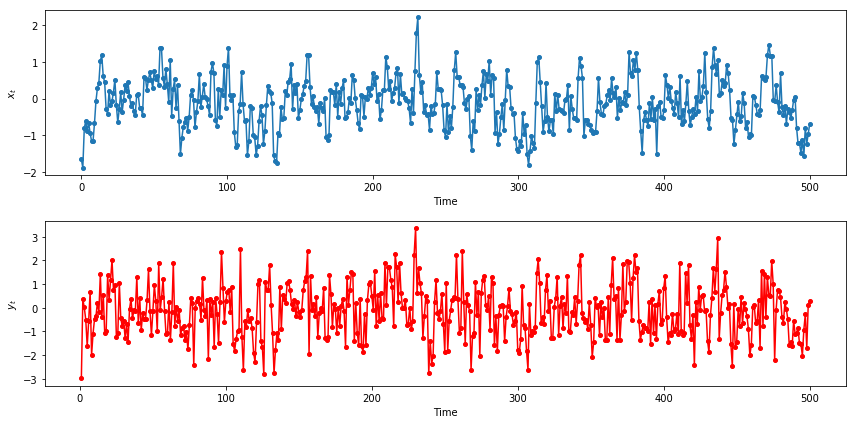

In [6]:
fig

## Sequential importance sampling

In [7]:
def sis(ys, n=200):
    # Length of data
    tmax = len(ys)
    
    # Pre-allocate
    xs = np.zeros((tmax + 1, n))
    ws = np.zeros((tmax + 1, n))
    wsnorm = np.zeros((tmax + 1, n))
    
    # Initialise
    xs[0, :] = randn(n)
    ws[0, :] = 1 / n * np.ones((n,))
    wsnorm[0, :] = ws[0, :]
    
    for t in range(tmax):
        # Propagate using proposal
        xs[t + 1, :] = 0.6 * xs[t, :] + 0.5 * randn(n)
        
        # Reweight
        tmp = (ys[t] - xs[t + 1, :]) / 0.8
        ws[t + 1, :] = ws[t, :] * \
            1 / (np.sqrt(2 * np.pi ) * 0.8) * \
            np.exp(-0.5 * tmp * tmp)
        # Normalize weights
        wsnorm[t + 1, :] = ws[t + 1, :] / np.sum(ws[t + 1, :])
        
    return xs, ws, wsnorm

In [8]:
xs, ws, wsnorm = sis(ys, n=30)

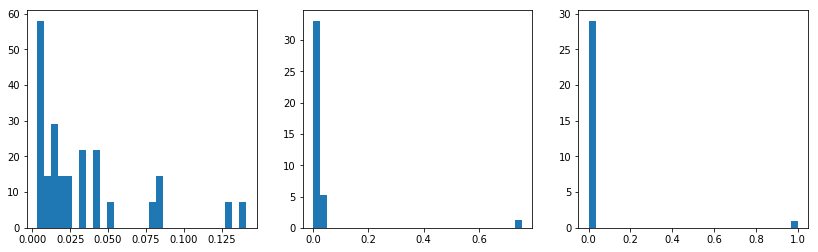

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

axs[0].hist(wsnorm[2, :], normed=True, bins=30);
axs[1].hist(wsnorm[10, :], normed=True, bins=30);
axs[2].hist(wsnorm[100, :], normed=True, bins=30);

## Bootstrap particle filter

In [10]:
def bpf(ys, n=200):
    # Length of data
    tmax = len(ys)
    
    # Pre-allocate
    xs = np.zeros((tmax + 1, n)); ancs = np.zeros((tmax + 1, n), dtype=np.int32)
    ws = np.zeros((tmax + 1, n)); wsnorm = np.zeros((tmax + 1, n))
    
    # Initialise
    xs[0, :] = randn(n)
    ws[0, :] = 1 / n * np.ones((n,))
    wsnorm[0, :] = ws[0, :]
    ancs[0, :] = range(n)
    
    for t in range(tmax):
        # Propagate using proposal
        xs[t + 1, :] = 0.6 * xs[t, ancs[t, :]] + 0.5 * randn(n)
        
        # Reweight, multiplying with previous weights not necessary since always 1 / n
        tmp = (ys[t] - xs[t + 1, :]) / 0.8
        ws[t + 1, :] = 1 / (np.sqrt(2 * np.pi ) * 0.8) * \
            np.exp(-0.5 * tmp * tmp)
        # Normalize weights
        wsnorm[t + 1, :] = ws[t + 1, :] / np.sum(ws[t + 1, :])
        
        # Resample
        ancs[t + 1, :] = choice(range(n), size=n, replace=True, p=wsnorm[t + 1, :])
        
    return xs, ancs, ws, wsnorm

In [11]:
xs, ancs, ws, wsnorm = bpf(ys)

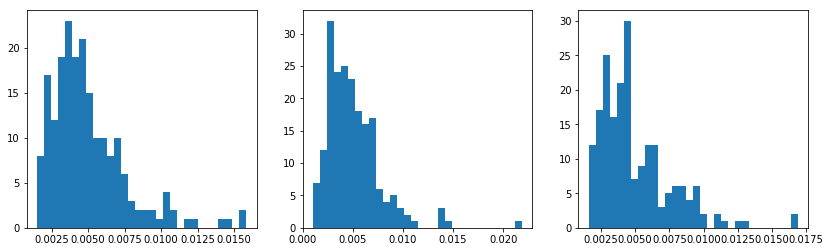

In [12]:
3fig, axs = plt.subplots(1, 3, figsize=(14, 4))

axs[0].hist(wsnorm[2, :], bins=30);
axs[1].hist(wsnorm[10, :], bins=30);
axs[2].hist(wsnorm[100, :], bins=30);